In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from sunpy.coordinates.sun import carrington_rotation_time
import scipy.stats as st
import datetime
from astropy.time import Time
import copy
import huxt as H
import huxt_analysis as HA
import huxt_inputs as HI
import astropy.units as u
import os

mpl.rcParams.update({'font.size': 14})

In [10]:
def load_ssn_sai():
    """
    Function to load in the monthly sunspot number data and compute the Solar Activity Index (SAI)
    Returns:
    ssn_df: A Pandas dataframe with the SSN and SAI data.
    """

    # Download from http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv
    filepath = "/Users/dven/repos/CME_transit_climatology_new/data/SN_m_tot_V2.0.csv"

    col_specification = [(0, 4), (5, 7), (8,16),(17,23),(24,29),(30,35)]
    ssn_df = pd.read_fwf(filepath, colspecs=col_specification,header=None)
    dfdt = np.empty_like(ssn_df[0], dtype=datetime.datetime)
    dftime = np.empty_like(ssn_df[0], dtype=Time)

    for i in range(0,len(ssn_df)):
        date_string = str(int(ssn_df[0][i])) + '-' + str(int(ssn_df[1][i])) + '-15'

        dfdt[i] = datetime.datetime(int(ssn_df[0][i]),int(ssn_df[1][i]),15)
        dftime[i] = Time(date_string, format='iso')

    #replace the index with the datetime objects
    ssn_df['datetime'] = dfdt
    ssn_df['time'] = dftime
    ssn_df["fracyear"] = ssn_df.apply(lambda row: row["time"].decimalyear, axis=1)
    ssn_df['ssn'] = ssn_df[3]
    ssn_df['jd'] = ssn_df.apply(lambda row: row["time"].jd, axis=1)

    #delete the unwanted columns
    ssn_df.drop(0,axis=1,inplace=True)
    ssn_df.drop(1,axis=1,inplace=True)
    ssn_df.drop(2,axis=1,inplace=True)
    ssn_df.drop(3,axis=1,inplace=True)
    ssn_df.drop(4,axis=1,inplace=True)
    ssn_df.drop(5,axis=1,inplace=True)

    #add the 13-month running smooth
    window = 13*30
    temp = ssn_df.rolling(str(window)+'D', on='datetime').mean()
    ssn_df['smooth'] = np.interp(ssn_df['jd'],temp['jd'],temp['ssn'], left =np.nan, right =np.nan)
    #drop the incomplete window at the start
    mask = ssn_df['jd'] < ssn_df['jd'].loc[0] + window/2
    ssn_df.loc[mask, 'smooth'] = np.nan

    #add in a solar activity index, which normalises the cycle magnitude
    #approx solar cycle length, in months
    nwindow = int(11*12)
    #find maximum value in a 1-solar cycle bin centred on current time
    ssn_df['rollingmax'] = ssn_df.rolling(nwindow, center = True).max()['smooth']
    #fill the max value at the end of the series
    fillval_end = ssn_df['rollingmax'].dropna().values[-1]
    fillval_start = ssn_df['rollingmax'].dropna().values[0]
    ssn_df['rollingmax'] = ssn_df['rollingmax'].fillna(fillval_end)
    #drop the incomplete window at the start
    mask = ssn_df['jd'] < (ssn_df['jd'].loc[0] + 11*365.25/2)
    ssn_df.loc[mask, 'rollingmax'] = fillval_start
    #create a Solar Activity Index, as SSN normalised to the max smoothed value in
    #1-sc window centred on current tim
    ssn_df['sai'] = ssn_df['smooth'] / ssn_df['rollingmax']
    return ssn_df



In [11]:
def plot_huxt_multi(ax, time, model):
    """
    Plot the HUXt solution at a specified time, and (optionally) overlay the modelled flank location and field of view
    of a specified observer.
    :param ax: Axes handle to plot in.
    :param time: The time to plot. The closest value in model.time_out is selected.
    :param model: A HUXt instance with the solution in.
    :return:
    """
    id_t = np.argmin(np.abs(model.time_out - time))

    # Get plotting data
    lon_arr, dlon, nlon = H.longitude_grid()
    lon, rad = np.meshgrid(lon_arr.value, model.r.value)
    mymap = mpl.cm.viridis
    v_sub = model.v_grid.value[id_t, :, :].copy()
    # Insert into full array
    if lon_arr.size != model.lon.size:
        v = np.zeros((model.nr, nlon)) * np.NaN
        if model.lon.size != 1:
            for i, lo in enumerate(model.lon):
                id_match = np.argwhere(lon_arr == lo)[0][0]
                v[:, id_match] = v_sub[:, i]
        else:
            print('Warning: Trying to contour single radial solution will fail.')
    else:
        v = v_sub

    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)

    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    levels = np.arange(200, 800 + 10, 10)
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')
    # Remove edgelines that appear in pdfs
    for c in cnt.collections:
        c.set_edgecolor("face")

    cme_colors = ['r', 'c', 'm', 'y', 'deeppink', 'darkorange']
    for j, cme in enumerate(model.cmes):
        cid = np.mod(j, len(cme_colors))
        cme_lons = cme.coords[id_t]['lon']
        cme_r = cme.coords[id_t]['r'].to(u.solRad)
        if np.any(np.isfinite(cme_r)):
            # Pad out to close the profile.
            cme_lons = np.append(cme_lons, cme_lons[0])
            cme_r = np.append(cme_r, cme_r[0])
            ax.plot(cme_lons, cme_r, '-', color=cme_colors[cid], linewidth=3)

    bodies = HA.get_body_styles()
    # Don't want STA or STB in these plots, so:
    bodies.pop('STA')
    bodies.pop('STB')

    # Add on observers
    for body, style in bodies.items():
        obs = model.get_observer(body)
        deltalon = 0.0*u.rad
        if model.frame == 'sidereal':
            earth_pos = model.get_observer('EARTH')
            deltalon = earth_pos.lon_hae[id_t] - earth_pos.lon_hae[0]

        obslon = H._zerototwopi_(obs.lon[id_t] + deltalon)

        if body == 'EARTH':
            ax.plot(obslon, obs.r[id_t], style['marker'], color=style['color'], markersize=16, label=body)
        elif (obs.r[id_t] > model.r.min()) & (obs.r[id_t] < model.r.max()):
            ax.plot(obslon, obs.r[id_t],  style['marker'], color=style['color'], markersize=16, label=body)

    ax.set_ylim(0, model.r.value.max())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.patch.set_facecolor('slategrey')
    return id_t



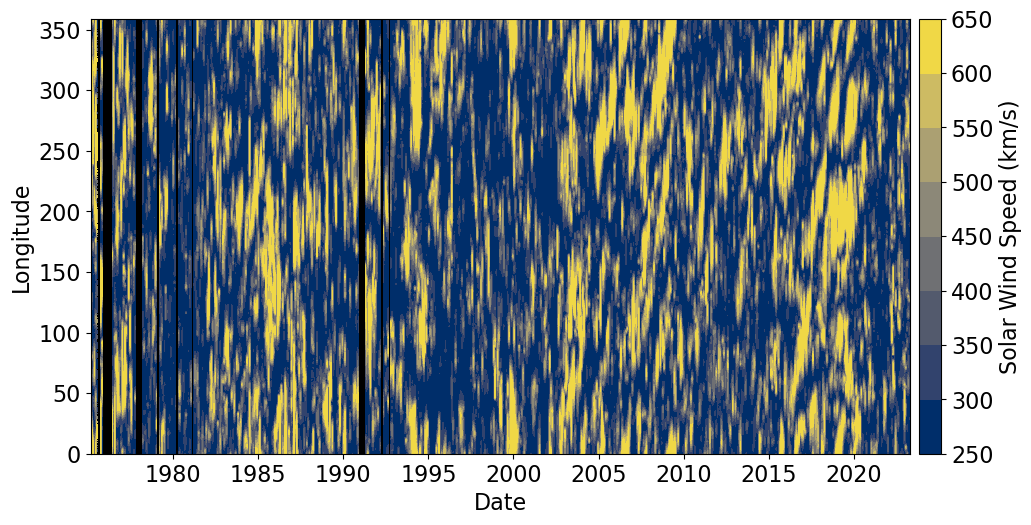

In [12]:
def solarwind_time_longitude_map_plot():
    """
    Produce a time-longitude plot of the MAS equatorial solar wind speed, to show how solar wind model boundary conditions change in time.
    """

    # load in the CME transit time data
    data_path = "/Users/dven/repos/CME_transit_climatology_new/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])

    cr_nums_pad = np.arange(cr_nums.min(), cr_nums.max() + 1, 1)
    cr_time_pad = carrington_rotation_time(cr_nums_pad + 0.5)
    vsw_bc = []

    for cr_num in cr_nums_pad:
        cr_tag = "CR_{}".format(cr_num)

        if cr_tag in cr_keys and 'vr_in' in data[cr_tag]:
            # Get BC variability
            vsw_bc.append(data[cr_tag + '/vr_in'][:])
        else:
            vsw_bc.append(np.nan*np.ones(360))

    vsw = np.array(vsw_bc)
    lons = np.arange(0,360,1)

    fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
    ax.set_facecolor('k')
    levels = np.arange(250, 700, 50)
    cmap = copy.copy(mpl.cm.get_cmap('cividis'))
    cmap.set_bad(color='k', alpha=1)

    cnt = ax.contourf(cr_time_pad.datetime, lons, vsw.T, levels=levels, cmap=cmap, vmin=levels[0], vmax=levels[-1])
    ax.set_xlabel('Date')
    ax.set_ylabel('Longitude')

    cbar = fig.colorbar(cnt, ax=ax, pad=0.01)
    cbar.ax.set_ylabel('Solar Wind Speed (km/s)')

    fig.subplots_adjust(left=0.075, bottom=0.11, right=1.05, top=0.98)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/MAS_Vsw_equator_timeseries.pdf"
    fig.savefig(fig_name)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/MAS_Vsw_equator_timeseries.png"
    fig.savefig(fig_name)

    data.close()
    return

solarwind_time_longitude_map_plot()

Figure 1. A time-longitude map of the equatorial solar wind speed from the MAS coronal model output. In this work these data are used as the boundary conditions to the HUXt solar wind simulations. Black vertical stripes mark Carrington rotations where the MAS solutions were unavailable.

Files already exist for CR1625


/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_6569/3618655923.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  halfway_id = np.int(np.fix(hit_id/2.0))
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_6569/2211777207.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mymap.set_ov

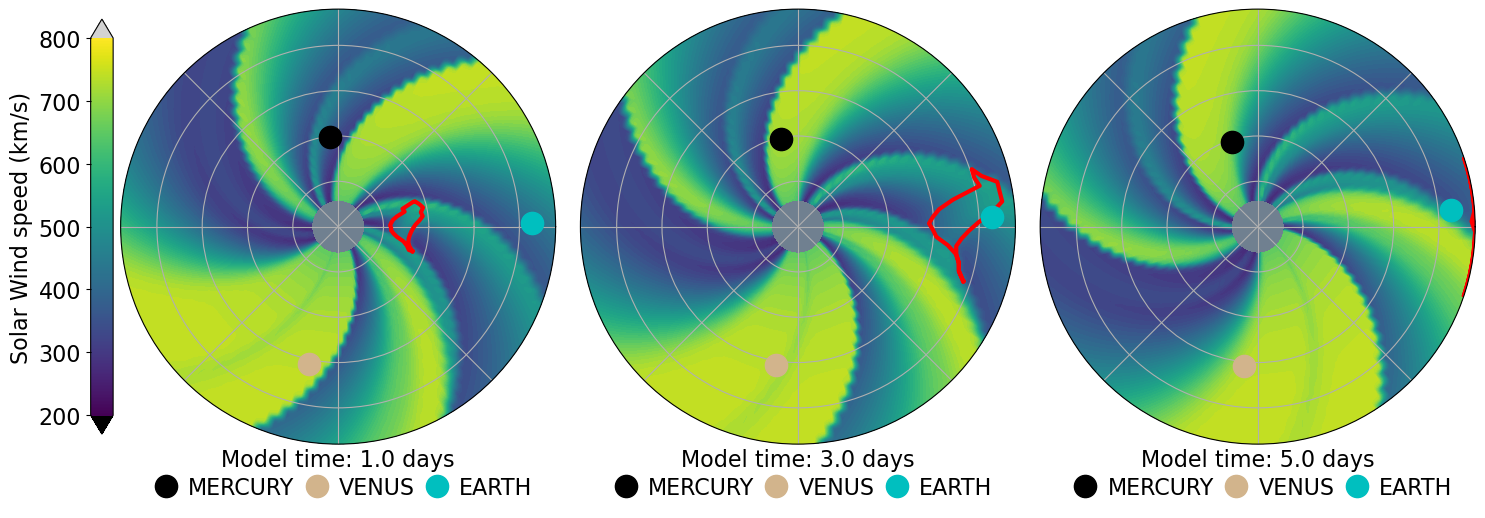

In [5]:
def plot_huxt_example():
    """
    Make example plot of Cone CME evolution.
    Returns:
    """
    # Run HUXt with climatological average CME and plot at 3 timesteps - initiation, middle, and arrival at Earth
    cme = H.ConeCME(t_launch=0 * u.day, longitude=0.0 * u.deg, width=37.4 * u.deg, v=495 * (u.km / u.s), thickness=0 * u.solRad)

    cr_num = 1625
    vr_mas = HI.get_MAS_long_profile(cr_num, lat=0.0 * u.deg)
    #  Setup HUXt to do a 6 day simulation, with model output every 4 timesteps (roughly half and hour time step)
    model = H.HUXt(v_boundary=vr_mas, cr_num=cr_num, cr_lon_init=0*u.deg, simtime=6*u.day, dt_scale=4, frame = 'sidereal')

    model.solve([cme])

    fig, ax = plt.subplots(1, 3, figsize=(15,5), subplot_kw={"projection": "polar"})

    cme = model.cmes[0]
    stats = cme.compute_arrival_at_body('Earth')
    hit_id = stats['hit_id']
    halfway_id = np.int(np.fix(hit_id/2.0))

    for a, time_out in zip(ax, [1*u.day, 3*u.day, 5*u.day]):

        id_t = plot_huxt_multi(a, time_out, model)

        label = "Model time: {:3.1f} days".format(model.time_out[id_t].to(u.day).value)
        a.text(0.5, -0.05,label, ha='center', fontsize=16, transform=a.transAxes)

    fig.subplots_adjust(left=0.075, bottom=0.12, right=0.99, top=0.99, wspace=0.015)

    mymap = mpl.cm.viridis
    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    norm = mpl.colors.Normalize(vmin=200,vmax=800)
    smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)

    pos = ax[0].get_position()
    dw = 0.02
    dh = 0.02
    left = pos.x0 - dw
    bottom = pos.y0 + dh
    width = 0.015
    height = pos.height - 2*dh
    cbaxes = fig.add_axes([left, bottom, width, height])
    cbar = fig.colorbar(smp, cax=cbaxes, orientation='vertical', extend='both')

    cbaxes.yaxis.set_ticks_position('left')
    cbaxes.yaxis.set_label_position('left')
    cbar.set_label('Solar Wind speed (km/s)')

    for a in ax:
        a.legend(bbox_to_anchor=(0.5, -0.1), loc="center", ncol=3, frameon=False, handletextpad=0.0, columnspacing=0.0)

    dirs = H._setup_dirs_()
    fig_name = 'cone_cme_example'
    fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".pdf")
    fig.savefig(fig_path)
    fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".png")
    fig.savefig(fig_path)
    return

plot_huxt_example()

In [27]:
def load_reduced_transit_data():
    """
    Function to load in the transit simulation data for all Carrington rotations and compute the median and interquartile range for each rotataion.
    Then the SSN and SAI are interpolated onto the CR times. This is done for both the average and fast CME scenarios.
    Returns:
    cme_avg: Pandas dataframe of transit time statistics and solar activity measures for the average CME scenario
    cme_fst: Pandas dataframe of transit time statistics and solar activity measures for the fast CME scenario
    """

    data_path = "/Users/dven/repos/CME_transit_climatology_new/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])
    cr_time = carrington_rotation_time(cr_nums+0.5)

    for cme_type in ["cme_average", "cme_fast"]:

        transit_avg = np.zeros(len(cr_nums))
        transit_var = np.zeros(len(cr_nums))
        transit_q1  = np.zeros(len(cr_nums))
        transit_q9  = np.zeros(len(cr_nums))
        vsw_mas_var = np.zeros(len(cr_nums))

        for i, (cr_key, cr_data) in enumerate(data.items()):
            
            if 'vr_in_std' in data[cr_key]:
                # Get BC variability
                vsw_mas_var[i] = cr_data['vr_in_std'][()]
                # Convert transits from days to hours
                transits = 24*cr_data[cme_type + '/t_transit'][:]
                transit_avg[i] = np.nanmedian(transits)
                transit_var[i] = st.iqr(transits, nan_policy="omit")
                quantiles = np.nanpercentile(transits, [10, 90])
                transit_q1[i] = quantiles[0]
                transit_q9[i] = quantiles[1]
            else:
                vsw_mas_var[i] = np.nan
                transits =  np.nan
                transit_avg[i] = np.nan
                transit_var[i] = np.nan
                quantiles = np.nan
                transit_q1[i] = np.nan
                transit_q9[i] = np.nan

        id_good = np.isfinite(transit_var) & np.isfinite(transit_avg)
        cr_nums_sub = cr_nums[id_good]
        cr_time_sub = cr_time[id_good]
        transit_avg = transit_avg[id_good]
        transit_q1 = transit_q1[id_good]
        transit_q9 = transit_q9[id_good]
        transit_var = transit_var[id_good]
        vsw_mas_var = vsw_mas_var[id_good]

        df = pd.DataFrame({'cr_num':cr_nums_sub, 'datetime':cr_time_sub.datetime, 'jd':cr_time_sub.jd, 'avg':transit_avg, 'iqr':transit_var,
                           'q1':transit_q1, 'q9':transit_q9, 'vsw_var':vsw_mas_var})

        if cme_type == 'cme_average':
            cme_avg = df.copy()
        elif cme_type == 'cme_fast':
            cme_fst = df.copy()

        del df

    # Load SSN and SAI
    ssn = load_ssn_sai()

    # Interpolate SAI onto the CME series
    cme_avg['sai'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['sai'])
    cme_fst['sai'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['sai'])

    cme_avg['ssn'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['ssn'])
    cme_fst['ssn'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['ssn'])

    data.close()
    return cme_avg, cme_fst

/opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


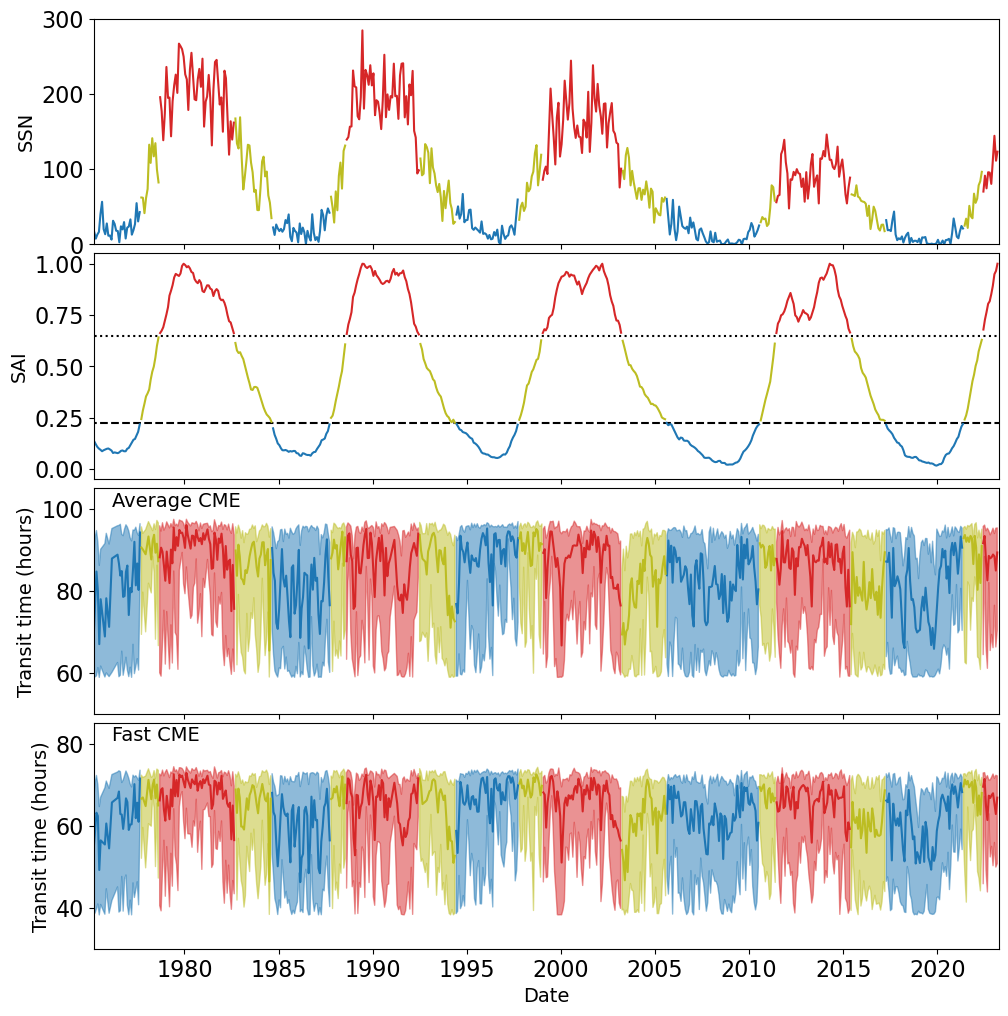

In [28]:
def solar_activity_and_transients_time_series():
    """
    Time series plot showing the evolution of SSN, SAI, and medians of transit time over each Carrington rotation of the study.
    Returns:

    """
    ssn = load_ssn_sai()
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(4,1, figsize=(10,10), facecolor='white')

    terciles = ssn['sai'].quantile([0.333, 0.666]).values
    colors = ['tab:blue', 'tab:olive', 'tab:red']

    id_low = ssn['sai'] <= terciles[0]
    id_mid = (ssn['sai'] >= terciles[0]) & (ssn['sai'] <= terciles[1])
    id_high = ssn['sai'] >= terciles[1]

    for id_sub, col in zip([id_low, id_mid, id_high], colors):

        # Make a copy of the ssn data, which we will mask to only show chosen tercile grouping
        ssn_c = ssn.copy()
        ssn_c[np.logical_not(id_sub)] = np.NaN

        # Sun spot number
        ax[0].plot(ssn_c['datetime'], ssn_c['ssn'], '-', color=col)
        # Solar activity index
        ax[1].plot(ssn_c['datetime'], ssn_c['sai'], '-', color=col)

    # Add horizontal lines showing the terciles
    linestyles = ['--', ':']
    ax[1].hlines(terciles, ssn['datetime'].min(), ssn['datetime'].max(), colors=['k'], linestyles=linestyles )

    for a, cme, label in zip(ax[2:], [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        for id_sub, col in zip([id_low, id_mid, id_high], colors):

            # Make a copy of CME data which we will mask to only show chosen tercile grouping
            cme_dup = cme.copy()
            cme_dup[np.logical_not(id_sub)] = np.NaN

            a.plot(cme_dup['datetime'], cme_dup['avg'], '-', color=col, zorder=2)
            a.fill_between(cme_dup['datetime'], cme_dup['q1'], cme_dup['q9'], color=col, alpha=0.5, zorder=1)

        a.text(0.02, 0.92, label, transform=a.transAxes, fontsize=14)

    for a in ax:
        a.set_xlim(cme_avg['datetime'].min(), cme_avg['datetime'].max())

    for a in ax[:-1]:
        a.set_xticklabels([])

    ax[0].set_ylim(0,300)
    ax[2].set_ylim(50,105)
    ax[3].set_ylim(30,85)

    ax[-1].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('SSN', fontsize=14)
    ax[1].set_ylabel('SAI', fontsize=14)
    ax[2].set_ylabel('Transit time (hours)', fontsize=14)
    ax[3].set_ylabel('Transit time (hours)', fontsize=14)

    fig.subplots_adjust(left=0.085, bottom=0.06, right=0.99, top=0.99, hspace=0.04)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/ssn_sai_cme_timeseries.pdf"
    fig.savefig(fig_name)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/ssn_sai_cme_timeseries.png"
    fig.savefig(fig_name)
    return

solar_activity_and_transients_time_series()

/opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


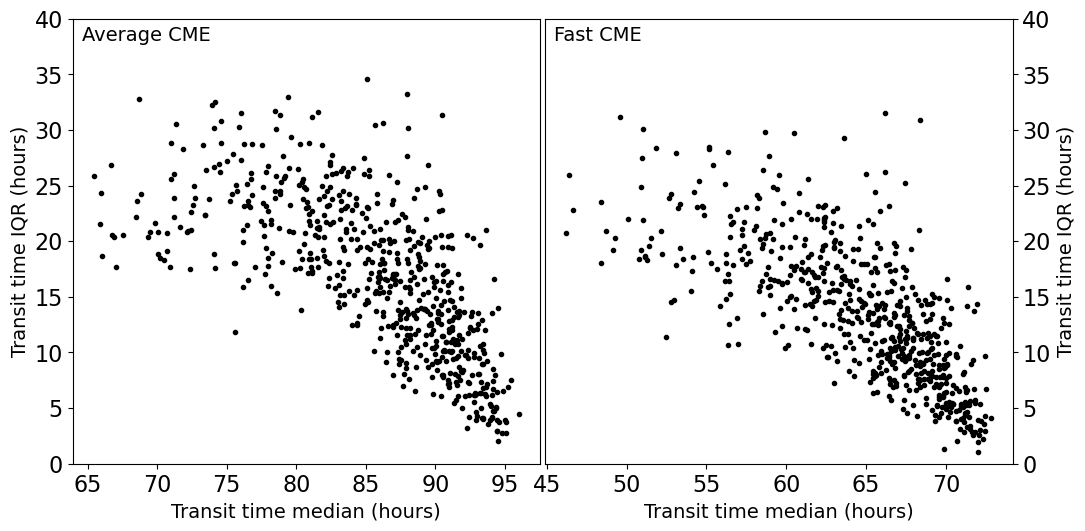

In [29]:
def transit_median_iqr_scatter():
    """
    Scatter plots of the CR median transit time vs transit time IQR for the average and fast CME scenarios
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    for a, cme, label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):
        a.plot(cme['avg'], cme['iqr'], 'k.')
        a.set_xlabel('Transit time median (hours)', fontsize=14)
        a.set_ylabel('Transit time IQR (hours)', fontsize=14)
        a.set_ylim(0,40)
        a.text(0.02, 0.95, label, transform=a.transAxes, fontsize=14)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.01)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/cme_transit_time_median_iqr_scatter.pdf"
    fig.savefig(fig_name)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/cme_transit_time_median_iqr_scatter.png"
    fig.savefig(fig_name)
    return

transit_median_iqr_scatter()

/opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Average CME
Total samples: 627
Samples in low tercile: 209
Samples in mid tercile: 208
Samples in high tercile: 209
Median for lower tercile 20.32907870784402
Median for middle tercile 16.627072426490486
Median for upper tercile 13.817802395671606
Fast CME
Total samples: 627
Samples in low tercile: 209
Samples in mid tercile: 208
Samples in high tercile: 209
Median for lower tercile 16.464013366028666
Median for middle tercile 12.77731353789568
Median for upper tercile 10.610745308920741


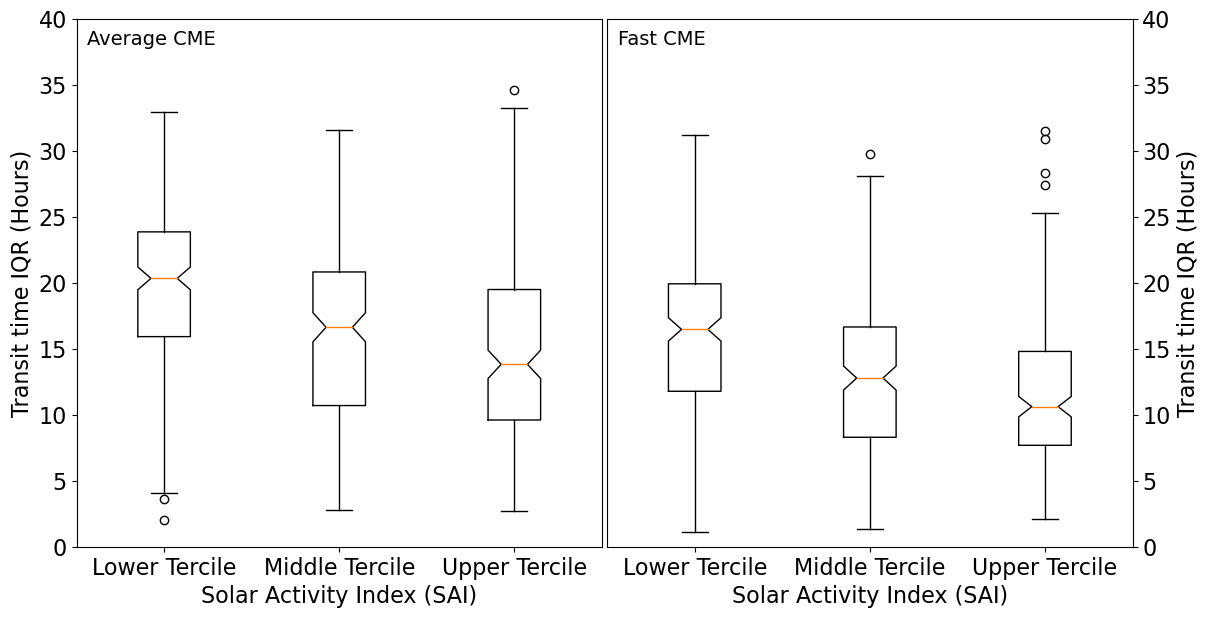

In [30]:
def boxplot_sai_transit_iqr():
    """
    Produce a boxplot of the distributions of the transit time IQR in each Carrington rotation partitioned by the terciles of the SAI distribution
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'iqr'], cme.loc[id_mid, 'iqr'], cme.loc[id_high, 'iqr']]
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        print('Median for lower tercile',np.median(boxplot_data[0]))
        print('Median for middle tercile',np.median(boxplot_data[1]))
        print('Median for upper tercile',np.median(boxplot_data[2]))
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Solar Activity Index (SAI)')
        a.set_ylabel('Transit time IQR (Hours)')
        a.set_ylim(0,40)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_transit_time_iqr_sai.pdf"
    fig.savefig(fig_name)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_transit_time_iqr_sai.png"
    fig.savefig(fig_name)
    return

boxplot_sai_transit_iqr()

2024-10-14 21:56:24 - py.warnings - WARNING: /opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)

2024-10-14 21:56:25 - py.warnings - WARNING: /opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)



Average CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208
Fast CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208


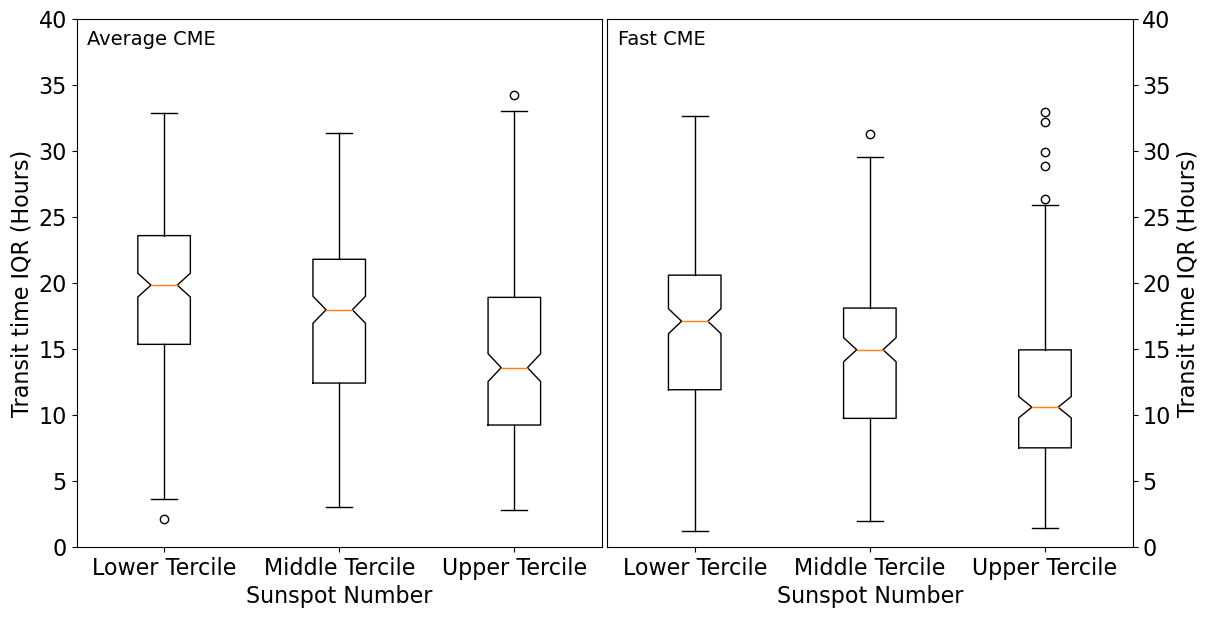

In [13]:
def boxplot_ssn_transit_iqr():
    """
    Produce a boxplot of the distributions of the transit time IQR in each Carrington rotation partitioned by the terciles of the SSN distribution
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['ssn'].quantile([0.333,0.666]).values

        id_low = cme['ssn'] <= terciles[0]
        id_mid = (cme['ssn'] > terciles[0]) & (cme['ssn'] <= terciles[1])
        id_high = cme['ssn'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'iqr'], cme.loc[id_mid, 'iqr'], cme.loc[id_high, 'iqr']]
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Sunspot Number')
        a.set_ylabel('Transit time IQR (Hours)')
        a.set_ylim(0,40)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_transit_time_iqr_ssn.pdf"
    fig.savefig(fig_name)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_transit_time_iqr_ssn.png"
    fig.savefig(fig_name)
    return

boxplot_ssn_transit_iqr()

2024-10-14 21:56:47 - py.warnings - WARNING: /opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)

2024-10-14 21:56:48 - py.warnings - WARNING: /opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)



Average CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208
Fast CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208


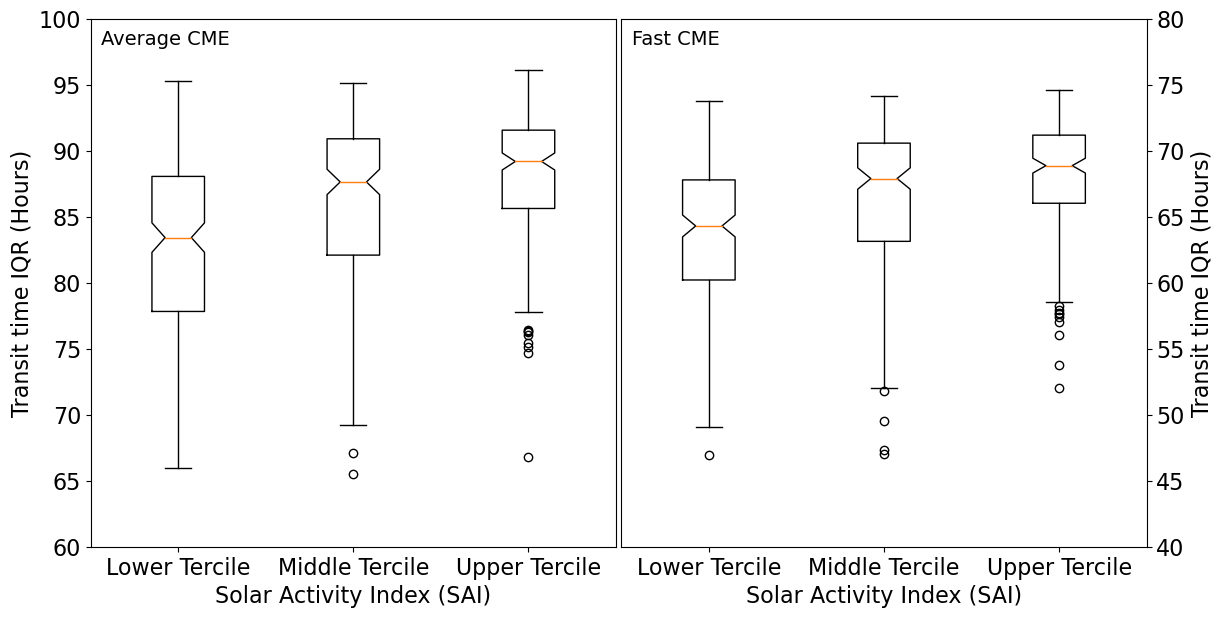

In [14]:
def boxplot_sai_transit_median():
    """
    Produce a boxplot of the distributions of the transit time median in each Carrington rotation partitioned by the terciles of the SAI distribution
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'avg'], cme.loc[id_mid, 'avg'], cme.loc[id_high, 'avg']]
        median_value = np.median(boxplot_data, axis=1)
        print('Median for lower tercile',median_value[0])
        print('Median for middle tercile',median_value[1])
        print('Median for upper tercile',median_value[2])
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Solar Activity Index (SAI)')
        a.set_ylabel('Transit time IQR (Hours)')

    ax[0].set_ylim(60,100)
    ax[1].set_ylim(40,80)
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_transit_time_median_sai.pdf"
    fig.savefig(fig_name)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_transit_time_median_sai.png"
    fig.savefig(fig_name)
    return

boxplot_sai_transit_median()

In [16]:
def load_transit_data():
    """
    Function to load in the transit simulation data for all Carrington rotations and compute the median and interquartile range for each rotataion.
    Then the SSN and SAI are interpolated onto the CR times. This is done for both the average and fast CME scenarios.
    Returns:
    cme_avg: Pandas dataframe of transit time statistics and solar activity measures for the average CME scenario
    cme_fst: Pandas dataframe of transit time statistics and solar activity measures for the fast CME scenario
    """

    data_path = "/Users/dven/repos/CME_transit_climatology_new/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])

    for cme_type in ["cme_average", "cme_fast"]:

        transits_agg = np.array([])
        v_agg = np.array([])
        cr_nums_agg = np.array([])

        for i, (cr_key, cr_data) in enumerate(data.items()):

            # Convert transits from days to hours
            transits = 24*cr_data[cme_type + '/t_transit'][:]
            transits_agg = np.append(transits_agg, transits)
            v_agg = np.append(v_agg, cr_data[cme_type + '/v'][:])
            cr_nums_agg = np.append(cr_nums_agg, cr_nums[i]*np.ones(transits.size))

        id_good = np.isfinite(transits_agg)
        cr_nums_agg = cr_nums_agg[id_good]
        transits_agg = transits_agg[id_good]
        v_agg = v_agg[id_good]

        cr_time_agg = carrington_rotation_time(cr_nums_agg + 0.5)

        df = pd.DataFrame({'cr_num':cr_nums_agg, 'datetime':cr_time_agg.datetime, 'jd':cr_time_agg.jd, 'transits':transits_agg, 'v':v_agg})

        if cme_type == 'cme_average':
            cme_avg = df.copy()
        elif cme_type == 'cme_fast':
            cme_fst = df.copy()

        del df

    # Load SSN and SAI
    ssn = load_ssn_sai()

    # Interpolate SAI onto the CME series
    cme_avg['sai'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['sai'])
    cme_fst['sai'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['sai'])

    cme_avg['ssn'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['ssn'])
    cme_fst['ssn'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['ssn'])

    data.close()
    return cme_avg, cme_fst

2024-10-14 21:59:28 - py.warnings - WARNING: /opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)

2024-10-14 21:59:29 - py.warnings - WARNING: /opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)



Average CME
Total samples: 16794
Samples in low tercile: 5616
Samples in mid tercile: 5589
Samples in high tercile: 5589
Fast CME
Total samples: 16794
Samples in low tercile: 5616
Samples in mid tercile: 5589
Samples in high tercile: 5589


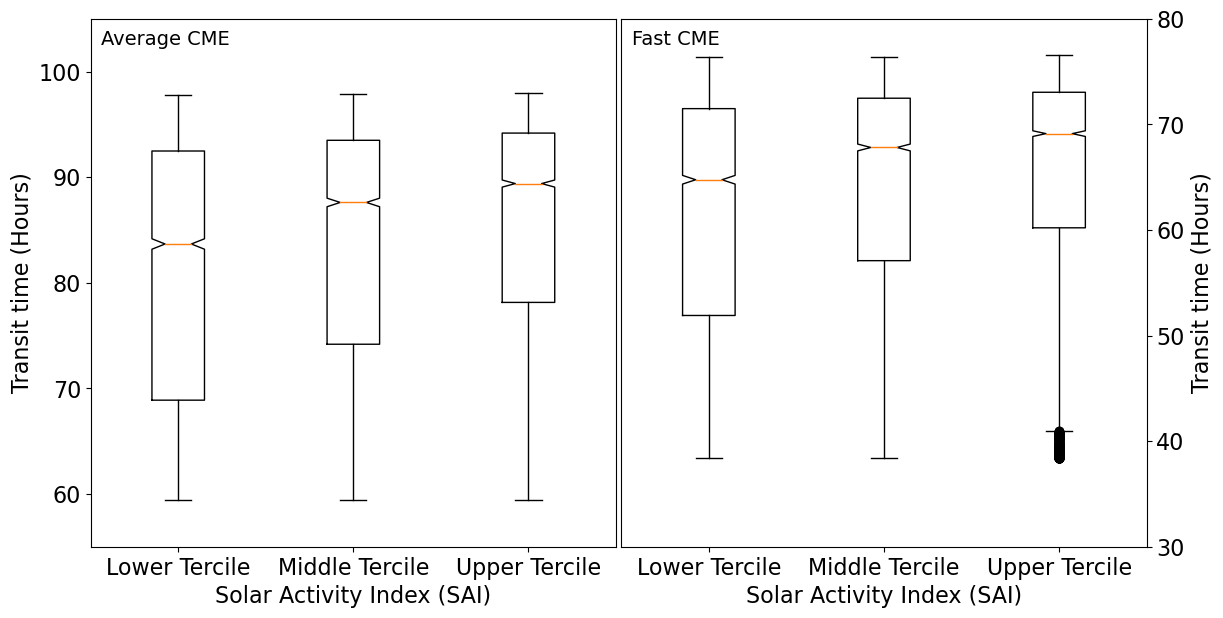

In [17]:
def boxplot_transits_sai():
    """
    Boxplot of the transit time distribution aggregated over all Carrington rotations, separated by the terciles of SAI.
    Returns:
    """

    cme_avg, cme_fst = load_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'transits'], cme.loc[id_mid, 'transits'], cme.loc[id_high, 'transits']]
        median_value = np.median(boxplot_data, axis=1)
        print('Median for lower tercile',median_value[0])
        print('Median for middle tercile',median_value[1])
        print('Median for upper tercile',median_value[2])
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Solar Activity Index (SAI)')
        a.set_ylabel('Transit time (Hours)')

    ax[0].set_ylim(55, 105)
    ax[1].set_ylim(30, 80)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_transit_time_all_sai.pdf"
    fig.savefig(fig_name)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_transit_time_all_sai.png"
    fig.savefig(fig_name)
    return

boxplot_transits_sai()

2024-10-14 22:00:17 - py.warnings - WARNING: /opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)

2024-10-14 22:00:17 - py.warnings - WARNING: /opt/miniconda3/envs/sir_huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)



Average CME
Total samples: 16794
Samples in low tercile: 5616
Samples in mid tercile: 5589
Samples in high tercile: 5589
Fast CME
Total samples: 16794
Samples in low tercile: 5616
Samples in mid tercile: 5589
Samples in high tercile: 5589


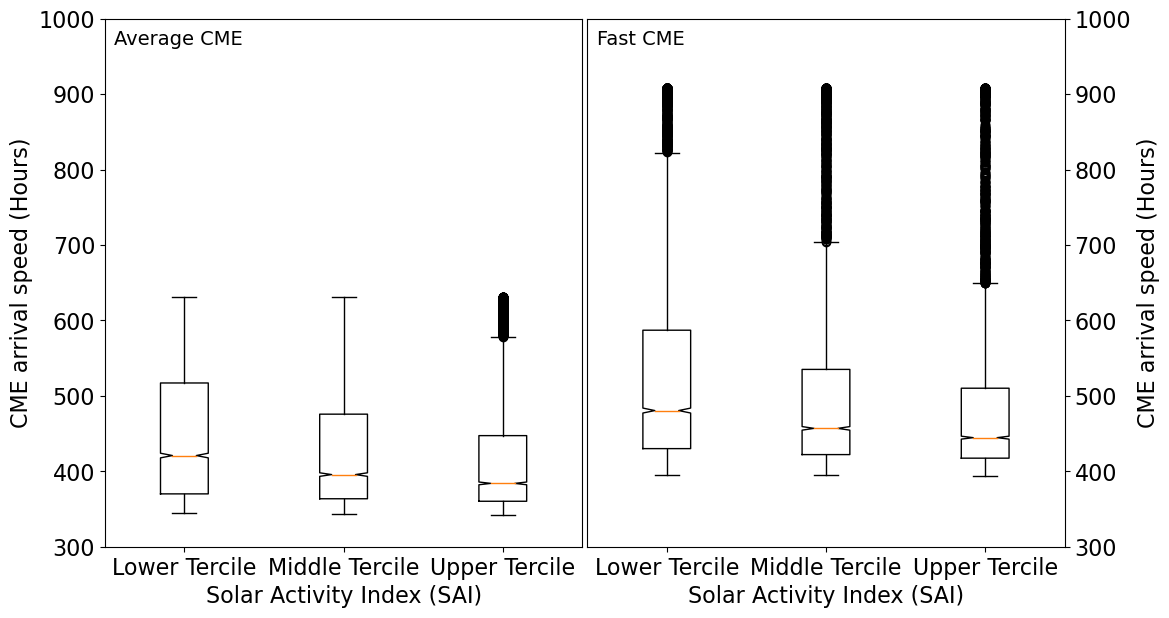

In [18]:
def boxplot_vcme_sai():
    """
    Boxplot of the transit time distribution aggregated over all Carrington rotations, separated by the terciles of SAI.
    Returns:
    """

    cme_avg, cme_fst = load_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'v'], cme.loc[id_mid, 'v'], cme.loc[id_high, 'v']]
        median_value = np.median(boxplot_data, axis=1)
        print('Median for lower tercile',median_value[0])
        print('Median for middle tercile',median_value[1])
        print('Median for upper tercile',median_value[2])
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Solar Activity Index (SAI)')
        a.set_ylabel('CME arrival speed (Hours)')

    ax[0].set_ylim(300, 1000)
    ax[1].set_ylim(300, 1000)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.98, wspace=0.01)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_vcme_all_sai.pdf"
    fig.savefig(fig_name)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/boxplot_vcme_all_sai.png"
    fig.savefig(fig_name)
    return

boxplot_vcme_sai()